# Roteiro Levenberg-Marquadt

Esse código é um protótipo de função para a implementação do algoritmo de Levenberg-Marquadt, o qual é utilizado para estimar parâmetros não-lineares. 

\begin{equation}
\Gamma (\textbf{m}) = \Psi (\textbf{m}) + \sum\limits^{6}_{j=1}\alpha_{j}\varphi_{j}(\textbf{m})
\end{equation}

In [1]:
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.gravmag import prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
import mag_polyprism_functions as mfun
import polyprism_tests as tests
% matplotlib inline

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


# Entrada

### Parâmetros para o modelo direto

In [3]:
M = 8 # number of vertices per prism
L = 10 # number of prisms
P = L*(M+2) # number of parameters

inc, dec = -60., 50. # inclination and declination of regional field
incs, decs = 70., -50.      # wrong direction or remanent

r = np.zeros(M) + 2000. # radial distance for each vertice
#r = np.zeros(M)
#r[::2] = 3000.
#r[1::2] = np.sqrt(2.)*3000.

# Cartesian coordinates of the origin of each prism
x0 = np.zeros(L) 
y0 = np.zeros(L)

dz = 100.0    # thickness of each prism

In [4]:
props={'magnetization': utils.ang2vec(3., inc, dec)} # physical property

z0 = 0.    # depth of the top the shallowest prism

l = []   # list of prisms

### creating the lis of prisms

for i in range(L):
    l.append([r, x0[i], y0[i], z0 + dz*i, z0 + dz*(i + 1), props])

### Pontos de observação

In [5]:
#area over which the data are calculated
#x minimum, x maximum, y minimum and y maximum
area = [-10000, 10000, -10000, 10000] 

#number of data along the y and x directions
shape = (80,80)

#total number of data
N = shape[0]*shape[1]

#coordinates x and y of the data
x = np.linspace(area[0],area[1],shape[0]) # points in x
y = np.linspace(area[2],area[3],shape[0]) # points in y
xp,yp = np.meshgrid(x,y)    # creating mesh points
xp = xp.ravel()
yp = yp.ravel()

#vertical coordinates of the data
zp = -350. - 500.*utils.gaussian2d(xp, yp, 17000, 21000, 21000, 18500, angle=21) # relief

# Gerando os dados preditos

In [6]:
m = mfun.param_vec(l, M, L) # true parameters vector

In [7]:
model = mfun.pol2cart(l, M, L) # list of classes of prisms

In [8]:
dobs = polyprism.tf(xp, yp, zp, model, inc, dec) # predict data

In [9]:
noise = np.random.normal(loc=0., scale=5., size=shape[0]*shape[0]) 

In [10]:
dobs += noise

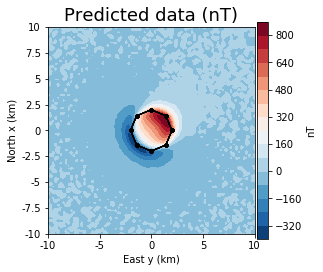

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title("Predicted data (nT)", fontsize = 18)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, dobs,shape, 15, cmap='RdBu_r')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
plt.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
for p in model:
    mpl.polygon(p, '.-k', xy2ne=True)
mpl.m2km()
plt.show()

# Algoritmo Levenberg-Marquadt

1- Iteração $k=0$: chute inicial $\mathbf{m}_0$ em que todos os elementos satisfaçam os vínculos de desigualdade e um valor real positivo grande para $\lambda$

2) Calcula os parâmetros transformados $\breve{\mathbf{m}}_k$

Os parâmetros transformados são calculados a partir da equação:

\begin{equation}
\breve{m}_i = f(m_i) = - \ln\left(\frac{m_{i\, max} - m_i}{m_i - m_{i\, min}}\right)
\end{equation}

A transformação inversa dos parâmetros é dada pela equação:

\begin{equation}
m_i = f^{-1}(\breve{m}_i) = m_{i\, min} + \left(\frac{m_{i\, max} - m_{i\, min}}{1 + e^{-\breve{m}_i}}\right)
\end{equation}

3) laço externo: calcula $\nabla^2\Gamma (\hat{\mathbf{m}}_k)$, $\nabla\Gamma (\hat{\mathbf{m}}_k)$ e $T(\hat{\mathbf{m}}_k)$:

### Parâmetros exigidos durante a inversão

In [12]:
lamb = 0.001 # Marquadt's parameter
dlamb = 5.  # step for Marquadt's parameter

# limits for parameters in meters
rmin = 0.
rmax = 5000.
x0min = -5000.
x0max = 5000.
y0min = -5000.
y0max = 5000.

In [13]:
mmax = np.zeros(M+2)
mmin = np.zeros(M+2)

mmax[:M] = rmax
mmax[M] = x0max
mmax[M+1] = y0max
mmin[:M] = rmin
mmin[M] = x0min
mmin[M+1] = y0min

mmax = np.resize(mmax, P)
mmin = np.resize(mmin, P)

In [14]:
delta = 10. # increment of derivatives

m_out = np.zeros(M + 2)  # outcropping body parameters

preg = 0.1000 # regularization parameter

In [15]:
#props={'magnetization': utils.ang2vec(3, inc, dec)} # physical property

#z0 = 0.    # depth of the top the shallowest prism

rini = np.full((M),(3000.))

lini = []   # list of parameters of each prisms

### creating the list of prisms
for i in range(L):
    lini.append([rini, x0[i], y0[i], z0 + dz*i, z0 + dz*(i + 1), props])

In [ ]:
alpha1 = 0.001 # adjacent radial distances within each prism
alpha2 = 0.001 # vertically adjacent radial distances
alpha3 = 0.    # outcropping cross-section
alpha4 = 0.    # outcropping origin
alpha5 = alpha1 # vertically adjacent origins
alpha6 = 0.0001 # zero order Tikhonov on adjacent radial distances

In [ ]:
itmax = 30
itmax_marq = 10
epsilon = 1.0e-4
gamma = 1.0e-7
    
lamb = 1.0e-4
dlamb = 10
l0 = deepcopy(lini)
m0 = mfun.param_vec(l0, M, L) # inicial parameters vector
model0 = mfun.pol2cart(l0, M, L) # list of classes of prisms
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec) # predict data
res = dobs - d0
phi0 = np.sum(res*res)/N
phi0 += mfun.phi_1(M, L, m0, alpha1) + mfun.phi_2(M, L, m0, alpha2) + \
        mfun.phi_3(M, L, m0, m_out, alpha3) + mfun.phi_4(M, L, m0, m_out[-2:], alpha4) + \
        mfun.phi_5(M, L, m0, alpha5) + mfun.phi_6(M, L, m0, alpha6)
phi_list = [phi0]
    
I = np.identity(P)
    
print '  0 %.5e' % (phi0)

i,j = np.diag_indices(P)

for it in range(itmax):
    mt = mfun.trans_parameter2(m0, M, L, mmax, mmin)
        
    #Jacobian matrix
    G = mfun.fd_tf_sm_polyprism(xp, yp, zp, l0, M, L, delta, delta, delta, inc, dec)

    grad = -2*np.dot(G.T, res)/N
    grad = mfun.gradient_phi_1(M, L, grad, alpha1)
    grad = mfun.gradient_phi_2(M, L, grad, alpha2)
    grad = mfun.gradient_phi_3(M, L, grad, m_out, alpha3)
    grad = mfun.gradient_phi_4(M, L, grad, m_out[-2:], alpha4)
    grad = mfun.gradient_phi_5(M, L, grad, alpha5)
    grad = mfun.gradient_phi_6(M, L, grad, alpha6)

    H = 2*np.dot(G.T, G)/N
    H = mfun.Hessian_phi_1(M, L, H, alpha1)
    H = mfun.Hessian_phi_2(M, L, H, alpha2)
    H = mfun.Hessian_phi_3(M, L, H, alpha3)
    H = mfun.Hessian_phi_4(M, L, H, alpha4)
    H = mfun.Hessian_phi_5(M, L, H, alpha5)
    H = mfun.Hessian_phi_6(M, L, H, alpha6)

    # Diagonal da matriz de positividade
    T = ((mmax - m0)*(m0 - mmin))/(mmax - mmin)

    for it_marq in range(itmax_marq): 

        S = H.copy()
        S[i,:] *= T
        S[i,j] += lamb

        delta_mt = np.linalg.solve(S, -grad)
        m_est = mfun.trans_inv_parameter2(mt + delta_mt, M, L, mmax, mmin)
        l_est = mfun.param2model(m_est, M, L, z0, dz, props)
        model_est = mfun.pol2cart(l_est, M, L)
        d_est = polyprism.tf(xp, yp, zp, model_est, inc, dec)
        res = dobs - d_est
        phi = np.sum(res*res)/N
        phi += mfun.phi_1(M, L, m_est, alpha1) + mfun.phi_2(M, L, m_est, alpha2) + \
                mfun.phi_3(M, L, m_est, m_out, alpha3) + mfun.phi_4(M, L, m_est, m_out[-2:], alpha4) + \
                mfun.phi_5(M, L, m_est, alpha5) + mfun.phi_6(M, L, m_est, alpha6)

        dphi = phi - phi0

        #print it, phi0, it_marq, phi, lamb

        if (dphi > 0.):
            lamb *= dlamb
        else:
            lamb /= dlamb
            print '%3d %.5e %3d %.3e' % (it, phi, it_marq, lamb)
            break

            

    if (abs(dphi/phi0) > epsilon):
        d0 = d_est
        m0 = m_est
        l0 = l_est
        phi0 = phi
        phi_list.append(phi0)
    else:
        break

  0 1.17706e+05
  0 9.25667e+04   0 1.000e-05
  1 7.43420e+04   0 1.000e-06
  2 6.56806e+04   0 1.000e-07
  3 6.27091e+04   0 1.000e-08
  4 6.18460e+04   0 1.000e-09
  5 6.15292e+04   0 1.000e-10
  6 6.13072e+04   0 1.000e-11
  7 6.11155e+04   0 1.000e-12
  8 6.09429e+04   0 1.000e-13
  9 6.07855e+04   0 1.000e-14
 10 6.06411e+04   0 1.000e-15
 11 6.05080e+04   0 1.000e-16
 12 6.03847e+04   0 1.000e-17
 13 6.02701e+04   0 1.000e-18
 14 6.01633e+04   0 1.000e-19
 15 6.00634e+04   0 1.000e-20
 16 5.99697e+04   0 1.000e-21
 17 5.98816e+04   0 1.000e-22
 18 5.97985e+04   0 1.000e-23
 19 5.97201e+04   0 1.000e-24
 20 5.96458e+04   0 1.000e-25
 21 5.95753e+04   0 1.000e-26
 22 5.95083e+04   0 1.000e-27
 23 5.94444e+04   0 1.000e-28
 24 5.93835e+04   0 1.000e-29
 25 5.93252e+04   0 1.000e-30
 26 5.92694e+04   0 1.000e-31
 27 5.92158e+04   0 1.000e-32
 28 5.91644e+04   0 1.000e-33


In [ ]:
A = np.arange(9.).reshape((3,3))
print A
i,j = np.diag_indices(3)
print i,j
t = np.arange(3.)
A[i,j] += 1.
print A

In [ ]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Fitted data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, d0,shape, 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.show()

In [ ]:
ddif = dobs - d0
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Residual data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, ddif,shape, 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.show()

In [ ]:
#m_volta = mfun.trans_inv_parameter(mt, M, L, rmin, rmax, x0min, x0max, y0min, y0max) # inverse transformation

#np.allclose(m_volta, m0) # validation test

# creating a model from the transformated parameters vector

#ltrans = [] # list of parameters of each prisms

#ii = i*(M+2)

### creating the list of prisms
#for i in range(L):
#    ltrans.append([mt[ii:ii+M], mt[ii+M], mt[ii+(M+1)], z0 + dz*i, z0 + dz*(i + 1), props])

#modeltrans = mfun.pol2cart(ltrans, M, L)

In [ ]:
np.mean(dobs - d0), np.std(dobs - d0)

In [ ]:
bounds = [-3000., 3000., -3000., 3000., -1000.0, 1000.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
myv.polyprisms(model, 'magnetization', opacity=1., color=blue)
myv.polyprisms(model_est, 'magnetization', opacity=.5, color=red)

myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])

scene.scene.camera.position = [-7807.4452530978979, -7807.4452530979024, -4486.7908303696386]
scene.scene.camera.focal_point = [0.0, 0.0, 600.0]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.0, 0.0, -1.0]
scene.scene.camera.clipping_range = [6256.115234984627, 19992.338744856861]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.savefig('bolacha.png')
myv.show()
img(filename='bolacha.png')

In [ ]:
0. = 2.

In [ ]:
def mq():
    itmax = 30
    itmax_marq = 10
    epsilon = 1.0e-4
    gamma = 1.0e-7
    
    lamb = 1.0e-4
    dlamb = 10
    l0 = deepcopy(lini)
    m0 = mfun.param_vec(l0, M, L) # inicial parameters vector
    model0 = mfun.pol2cart(l0, M, L) # list of classes of prisms
    d0 = polyprism.tf(xp, yp, zp, model0, inc, dec) # predict data
    res = dobs - d0
    phi0 = np.sum(res*res)/N
    phi0 += mfun.phi_1(M, L, m0, alpha1) + mfun.phi_2(M, L, m0, alpha2) + \
            mfun.phi_3(M, L, m0, m_out, alpha3) + mfun.phi_4(M, L, m0, m_out[-2:], alpha4) + \
            mfun.phi_5(M, L, m0, alpha5) + mfun.phi_6(M, L, m0, alpha6)
    phi_list = [phi0]
    
    I = np.identity(P)
    
    print '  0 %.5e' % (phi0)

    i,j = np.diag_indices(P)

    for it in range(itmax):
        mt = mfun.trans_parameter2(m0, M, L, mmax, mmin)
        
        #Jacobian matrix
        G = mfun.fd_tf_sm_polyprism(xp, yp, zp, l0, M, L, delta, delta, delta, inc, dec)

        grad = -2*np.dot(G.T, res)/N
        grad = mfun.gradient_phi_1(M, L, grad, alpha1)
        grad = mfun.gradient_phi_2(M, L, grad, alpha2)
        grad = mfun.gradient_phi_3(M, L, grad, m_out, alpha3)
        grad = mfun.gradient_phi_4(M, L, grad, m_out[-2:], alpha4)
        grad = mfun.gradient_phi_5(M, L, grad, alpha5)
        grad = mfun.gradient_phi_6(M, L, grad, alpha6)

        H = 2*np.dot(G.T, G)/N
        H = mfun.Hessian_phi_1(M, L, H, alpha1)
        H = mfun.Hessian_phi_2(M, L, H, alpha2)
        H = mfun.Hessian_phi_3(M, L, H, alpha3)
        H = mfun.Hessian_phi_4(M, L, H, alpha4)
        H = mfun.Hessian_phi_5(M, L, H, alpha5)
        H = mfun.Hessian_phi_6(M, L, H, alpha6)

        # Diagonal da matriz de positividade
        T = ((mmax - m0)*(m0 - mmin))/(mmax - mmin)

        for it_marq in range(itmax_marq): 

            S = H.copy()
            S[i,:] *= T
            S[i,j] += lamb

            delta_mt = np.linalg.solve(S, -grad)
            m_est = mfun.trans_inv_parameter2(mt + delta_mt, M, L, mmax, mmin)
            l_est = mfun.param2model(m_est, M, L, z0, dz, props)
            model_est = mfun.pol2cart(l_est, M, L)
            d_est = polyprism.tf(xp, yp, zp, model_est, inc, dec)
            res = dobs - d_est
            phi = np.sum(res*res)/N
            phi += mfun.phi_1(M, L, m_est, alpha1) + mfun.phi_2(M, L, m_est, alpha2) + \
                   mfun.phi_3(M, L, m_est, m_out, alpha3) + mfun.phi_4(M, L, m_est, m_out[-2:], alpha4) + \
                   mfun.phi_5(M, L, m_est, alpha5) + mfun.phi_6(M, L, m_est, alpha6)

            dphi = phi - phi0

            #print it, phi0, it_marq, phi, lamb

            if (dphi > 0.):
                lamb *= dlamb
            else:
                lamb /= dlamb
                print '%3d %.5e %3d %.3e' % (it, phi, it_marq, lamb)
                break

            

        if (abs(dphi/phi0) > epsilon):
            d0 = d_est
            m0 = m_est
            l0 = l_est
            phi0 = phi
            phi_list.append(phi0)
        else:
            break

In [ ]:
%lprun -f mq mq()

a) laço interno: calcula $\Delta \breve{\mathbf{m}}_k$ solucionando o sistema linear abaixo

\begin{equation}
\left[\nabla^2\Gamma (\hat{\mathbf{m}}_k) + \lambda \mathbf{I} \right]\mathbf{T}(\hat{\mathbf{m}}_k) \Delta\breve{\mathbf{m}}_k \approx - \nabla \Gamma (\hat{\mathbf{m}}_k)
\end{equation}

onde $\mathbf{T}(\hat{\mathbf{m}}_k)$ é uma matriz diagonal
\begin{equation}
[\mathbf{T}(\hat{\mathbf{m}}_k)]_{ii} = \frac{(m_{i\, max} - m_i)(m_i - m_{i\, min})}{(m_{i\, max} - m_{i\, min})}
\end{equation}

b) calcula $\breve{\mathbf{m}}_{k+1} = \breve{\mathbf{m}}_k + \Delta\breve{\mathbf{m}}_k$

c) computa $\hat{\mathbf{m}}_{k+1}$

d) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ 

   i $\lambda = \lambda\cdot d\lambda$

   ii retorne para 3)a)

e) $\lambda = \lambda/d\lambda$

4) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ e $\frac{|\Gamma (\hat{\mathbf{m}}_{k+1})- \Gamma (\hat{\mathbf{m}}_k)|}{|\Gamma (\hat{\mathbf{m}}_k)|}>\varepsilon$

a) $k=k+1$

b) Retorne para etapa 2)